# Réalisez une application mobile de recommandation de contenu

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans, SVD, KNNBasic
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
import requests
from timeit import default_timer as timer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

CLICK_THRESHOLD = 0
SCORE_SAMPLE = 100
DISPLAY_MODE = 1

## Exploration des données

In [2]:
# Preprocess des articles et de leurs catégories
PATH_ARTICLES_DATA = "./data/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)
articles_df = articles_df[["article_id", "category_id", "words_count"]]
articles_df = articles_df.set_index("article_id")
article_to_category = articles_df['category_id'].to_dict()

In [3]:
articles_df.head()

,category_id,words_count
article_id,,
0,0,168
1,1,189
2,1,250
3,1,230
4,1,162


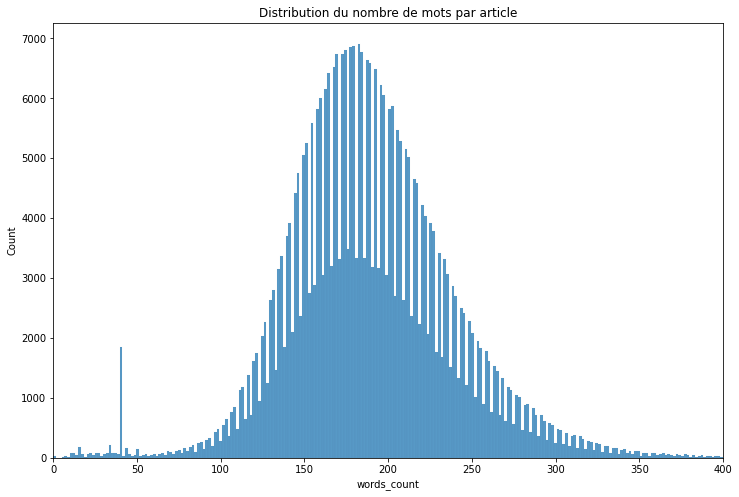

In [4]:
if DISPLAY_MODE:
    articles_df['words_count'].describe()
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.histplot(articles_df['words_count'],  ax=ax)
    plt.xlim([0,400])
    plt.title('Distribution du nombre de mots par article');
    plt.show()

In [5]:
PREPROCESS = 0

df_file = './clicks_df.csv'

if not os.path.isfile(df_file) or PREPROCESS:
    # chargement des fichier d'historique
    CLICK_FILES_PATH = "./data/clicks/"
    click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)]
    click_files.sort()
    clicks_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files]
    # on ne garde que les colones qui nous intéressent
    clicks_df = [x.drop(columns = ['session_id',
                                   'session_start',
                                   'session_size',
                                   'click_timestamp',
                                   'click_environment',
                                   'click_deviceGroup',
                                   'click_os',
                                   'click_country',
                                   'click_region',
                                   'click_referrer_type']) for x in clicks_df]
    clicks_df = pd.concat(clicks_df, axis=0, ignore_index=True)
    # on calcule la fréquence des catégories associées aux articles pour chaque utilisateur
    clicks_df['category_id'] = clicks_df['click_article_id'].map(article_to_category).astype(int)
    clicks_df['total_click'] = clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
    clicks_df['total_click_by_category_id'] = clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
    clicks_df['category_click_rate'] = clicks_df['total_click_by_category_id'] / clicks_df['total_click']
    clicks_df = clicks_df.drop(["total_click", "total_click_by_category_id"], axis=1)
    # statistiques
    old_users = clicks_df.user_id.nunique()
    old_shape = clicks_df.shape[0]
    clicks_df = clicks_df[clicks_df['user_id'].isin(clicks_df['user_id'].value_counts()[clicks_df['user_id'].value_counts()>CLICK_THRESHOLD].index)]
    new_users = clicks_df.user_id.nunique()
    print(f"Suppression de {old_users - new_users} utilisateurs (moins de {CLICK_THRESHOLD} visites)")
    print(f"{new_users} utilisateurs restants")
    print(f"La taille de l'historique est passée de {old_shape} à {clicks_df.shape[0]}")
    # sauvegarde
    clicks_df.to_csv(df_file, index=False)

else:
    clicks_df = pd.read_csv(df_file)
    
clicks_df.head()

,user_id,click_article_id,category_id,category_click_rate
0,1,235840,375,0.166667
1,1,96663,209,0.083333
2,3,236065,375,0.764706
3,3,236294,375,0.764706
4,5,168868,297,0.011494


In [6]:
# préparation des données pour l'exploitation
left_users = set(clicks_df['user_id'].to_list())
left_articles = set(clicks_df['click_article_id'].to_list())
articles_index = clicks_df.click_article_id.value_counts().index
hash_table = {j: i for i, j in enumerate(articles_index)}

# fonction de scoring des modèles
def score(model, func):
    total = 0
    total_correct = 0
    selected_users = random.sample(left_users, SCORE_SAMPLE)
    predictions = defaultdict(list) 
    for user in selected_users:
        if model=="CustomContentBased":
            predictions[user].extend(func(user))
        else:
            predictions[user].extend(func(model, user))
    for user_id in predictions:
        user_cats = set(clicks_df[clicks_df["user_id"]==user_id]["category_id"].to_list())
        pred_cats = [*map(lambda x: article_to_category[x[0]] in user_cats, predictions[user_id])]
        total += len(pred_cats)
        total_correct += sum(pred_cats)

    return float(total_correct) / total

## SVD & Collaborative filtering (KNN)

In [7]:
# fonction qui retourne les prédictions associées à un modèle de collaborative filtering pour un utilisateur donné
def get_CF_predictions(model, user_id, n=5):
    user_articles = set(clicks_df[clicks_df["user_id"]==user_id]["click_article_id"].to_list())
    scores = [(article, model.predict(user_id, article).est) for article in left_articles if article not in user_articles]
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:n]

# préparation des données pour la librairie Surprise
reader = Reader(rating_scale=(0, 1))
train_ds = Dataset.load_from_df(clicks_df[['user_id', 'click_article_id', 'category_click_rate']], reader)
train_set = train_ds.build_full_trainset()

In [8]:
# entrainement et scoring du modèle SVD
trained = 1

if not trained:
    t0 = timer()
    svd_model = SVD().fit(train_set)
    with open(r"baseline.pickle", "wb") as output_file:
        pickle.dump(svd_model, output_file)
    t1 = timer() - t0
    print(f"Training time: {t1}")
    
else:
    with open(r"baseline.pickle", "rb") as input_file:
        svd_model = pickle.load(input_file)
        
# score(svd_model, get_CF_predictions)

if DISPLAY_MODE:
    print("Training time: 95.9952094\nScore: 0.208")

Training time: 95.9952094
Score: 0.208


In [13]:
# entrainement et scoring du modèle de collaborative filtering (KNN)
trained = 1

if not trained:
    t0 = timer()
    sim_options = {
        "name": "cosine",
        "user_based": False,
    }

    KNN_model = KNNBasic(k=100, min_k=5, sim_options=sim_options).fit(train_set)
    with open(r"knn.pickle", "wb") as output_file:
        pickle.dump(KNN_model, output_file)
    t1 = timer() - t0
    print(f"Training time: {t1}")
    
else:
    with open(r"knn.pickle", "rb") as input_file:
        KNN_model = pickle.load(input_file)
        
# score(KNN_model, get_CF_predictions)

if DISPLAY_MODE:
    print("Training time: 100.8639531\nScore: 0.256")

Training time: 100.8639531
Score: 0.256


## Recommendations Content-Based

In [12]:
# chargement de l'embedding et des tables de coefficients de similarité 
embedding = pd.read_pickle('./data/articles_embeddings.pickle')
embedding = embedding[articles_index]
sim_file = 'cosine_similarities.npy'
if not os.path.isfile(sim_file):
    cosine_similarities = cosine_similarity(embedding, embedding)
    with open(sim_file, 'wb') as f:
        np.save(f, cosine_similarities)
else:
    with open(sim_file, 'rb') as f:
        cosine_similarities = np.load(f)
        
# fonction qui retourne les prédictions associées au modèle custom de recommendations content-based pour un utilisateur donné      
def get_CB_predictions(userId, n=5):  
    usrArt = clicks_df[clicks_df['user_id']==userId].click_article_id.to_list()
    usrArtLocal = [hash_table[x]for x in usrArt]
    sim_scores = [0 for i in range(cosine_similarities.shape[0])]
    for candidate in range(cosine_similarities.shape[0]):
        if candidate not in usrArtLocal:
            for tmpArt in usrArtLocal:
                sim_scores[candidate] += cosine_similarities[candidate][tmpArt]
    sim_scores = [(i, j) for i, j in enumerate(sim_scores)]
    sim_scores.sort(key=lambda x: x[1], reverse=True)
    
    return [(articles_index[x[0]], x[1]) for x in sim_scores[:n]]

# score("CustomContentBased", get_CB_predictions)

if DISPLAY_MODE:
    print("No training\nScore: 0.842")

No training
Score: 0.842


## Tests

In [11]:
import unittest

class TestStringMethods(unittest.TestCase):

    def test_svd(self):
        res = get_CF_predictions(svd_model, 1)
        res = [r[0] for r in res]
        self.assertEqual(len(res), 5)
        for r in res:
            self.assertTrue(r in left_articles)

    def test_cf(self):
        res = get_CF_predictions(KNN_model, 1)
        res = [r[0] for r in res]
        self.assertEqual(len(res), 5)
        self.assertTrue(all([r in left_articles for r in res]))

    def test_cb(self):
        res = get_CB_predictions(1)
        res = [r[0] for r in res]
        self.assertEqual(len(res), 5)
        self.assertTrue(all([r in left_articles for r in res]))
            
    def test_api(self):
        res = requests.post('https://oc-p9.azurewebsites.net/api/httptrigger1', json={'userId': 1})
        res = [*map(int, res.text[1:-1].split(', '))]
        self.assertEqual(len(res), 5)
        self.assertTrue(all([r in left_articles for r in res]))

unittest.main(argv=[''], verbosity=2, exit=False)

test_api (__main__.TestStringMethods) ... ok
test_cb (__main__.TestStringMethods) ... ok
test_cf (__main__.TestStringMethods) ... ok
test_svd (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 4 tests in 18.143s

OK
